Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


In [2]:
df_0 = pd.read_csv('Data/Model_Training_Data_0.csv')
df_20 = pd.read_csv('Data/Model_Training_Data_20.csv')
df_40 = pd.read_csv('Data/Model_Training_Data_40.csv')


df_0.columns = ["Time", "Current", "Voltage"]
df_20.columns = ["Time", "Current", "Voltage"]
df_40.columns = ["Time", "Current", "Voltage"]

# Create a Current_Change column
df_40["Current_Change"] = df_40["Current"].diff().astype('float64')
df_20["Current_Change"] = df_20["Current"].diff().astype('float64')
df_0["Current_Change"] = df_0["Current"].diff().astype('float64')
# Create a new column Prev_Current which is the previous current
df_40["Prev_Current"] = df_40["Current"].shift(1).astype('float64')
df_20["Prev_Current"] = df_20["Current"].shift(1).astype('float64')
df_0["Prev_Current"] = df_0["Current"].shift(1).astype('float64')
# Create a voltage change column
df_40["Voltage_Change"] = df_40["Voltage"].diff().astype('float64')
df_20["Voltage_Change"] = df_20["Voltage"].diff().astype('float64')
df_0["Voltage_Change"] = df_0["Voltage"].diff().astype('float64')
# Create a new column Prev_Voltage which is the previous voltage
df_40["Prev_Voltage"] = df_40["Voltage"].shift(1).astype('float64')
df_20["Prev_Voltage"] = df_20["Voltage"].shift(1).astype('float64')
df_0["Prev_Voltage"] = df_0["Voltage"].shift(1).astype('float64')

# Creat a rolling sum of the 10 past voltage changes
df_40["Rolling_Voltage_Change"] = df_40["Voltage_Change"].rolling(10).sum().astype('float64')
df_20["Rolling_Voltage_Change"] = df_20["Voltage_Change"].rolling(10).sum().astype('float64')
df_0["Rolling_Voltage_Change"] = df_0["Voltage_Change"].rolling(10).sum().astype('float64')


df_40.fillna(0, inplace=True)
df_20.fillna(0, inplace=True)
df_0.fillna(0, inplace=True)


# 1. Calculate R0,R1,C

Load the dataframes, and start and end indices of each pulse calculated in the Part2IntialCode

In [3]:
with open('Results\sub_matrices.pkl', 'rb') as f:
    sub_matrices = pickle.load(f)

I go through the matrix, extracting the instantaneous change in voltage, settling time, and steady state voltage rise that we need to calculate R0,R1,C1

In [4]:
dfs = [df_0, df_20, df_40] # list of dataframes to loop through

v_min_vals = np.ndarray((3,8,4)) # minimum voltage attained during discharge
v_inst_changes = np.ndarray((3,8,4)) # instantaneous voltage rise after the discharge stops
v_settling_changes = np.ndarray((3,8,4)) # total voltage rise after discharge stops and the battery settles
t_settling_times =  np.ndarray((3,8,4)) # time taken for the voltage to settle after discharge stops
delta_curr = np.ndarray((3,8,4)) # change in current from t-1 to t ( -2.5,-5,-10 or -20 depending on the discharge)
curr = np.ndarray((3,8,4)) # current at time t 


for n in range(3): # Loop through each dataframe
    df = dfs[n]
    sub_matrix = sub_matrices[n] # Select relevant indices

    for j in range(len(sub_matrix)): # Loop through each SOC
        for k in range(len(sub_matrix[j])): # Loop through each of the 4 charge-discharge cycles

            start_idx, end_idx = sub_matrix[j][k] # Select the start and end indices for the discharge cycle
            df_temp = df[start_idx:end_idx] # Select the relevant data and store in a temporary dataframe

            # 1. Find the instantanious voltage rise: Just when current rises from -x to 0

            # Get the index of the point where current changes from -x to 0 : we expect only one such point
            idx = df_temp[(df_temp.Current_Change > 0.1) & (df_temp.Prev_Current < 0) & (df_temp.Voltage_Change > 0)].index.to_list()
            if len(idx) != 1:
                print(f"{n,j,k} has this many instant voltage change points:{len(idx)}" ) # If this happens refine the above condition
            idx = idx[0] # select the index

            df_zoom = df[idx-10:idx+10] # zoom in on the region of interest

            v_change = df_temp.loc[idx,"Voltage_Change"] # Get the voltage change at this point
            v_inst_changes[n,j,k] = v_change # Add voltage change to our matrix
            delta_curr[n,j,k] = df_temp.loc[idx,"Current_Change"] # Store the current change
            curr[n,j,k] = df_temp.loc[idx,"Prev_Current"] # Store the previous non-zero current that caused the voltage change

            idx_v_change = idx # store this index
            

            # 2. Find the total voltage rise: Just before the point where current rises from 0 to smt positive
            
            # Get the index of the point where current changes from 0 to +x : we expect only one such point
            idx = df_temp[(df_temp.Current_Change > 0.1) & (abs(df_temp.Prev_Current) < 0.01)& (df_temp.Voltage_Change > 0)].index.to_list()
            if len(idx) != 1:
                print(f"{n,j,k} has this many instant voltage change points:{len(idx)}" )
            idx = idx[0] - 5 # go back 5 timesteps just to be safe, because in one step voltage will rise 
            df_temp.loc[idx]

            v_settled = df_temp.loc[idx,"Voltage"] # Get this settled voltage
            v_min = df_temp.Voltage.min() # Get the minimum voltage attained during discharge
            v_min_vals[n,j,k] = v_min  # Store the minimum voltage
            v_settling_changes[n,j,k] = v_settled - v_min # Store change between minimum and settled voltage

            idx_v_settled = idx # store the index
            
            # 3. Find the settling time - When the voltage is settled for a periof of time and is close to our settled voltage
            
            #idx = df_temp[(df_temp.index > idx_v_change) & (df_temp.Voltage ==  v_settled) & (df_temp.Rolling_Voltage_Change == 0 )].index.to_list()
            #idx = df_temp[(df_temp.index > idx_v_change) & (df_temp.Voltage > 0.99 * v_settled) &  (df_temp.Voltage < 1.001 * v_settled) & (df_temp.Rolling_Voltage_Change == 0 )].index.to_list()
            
            
            v_tolerance = 0.00
            rolling_v_tolerance = 0.01
            v_change_tolerance = 0.00


            idx = df_temp[(df_temp.index > idx_v_change) # this point is after the discharge concludes
                          & (df_temp.Voltage > (1*v_tolerance) * v_settled)  # within x% of the settled voltage we found above
                          & (df_temp.Voltage < (1 + v_tolerance) * v_settled) 
                          & (df_temp.Rolling_Voltage_Change <= rolling_v_tolerance ) # the total v_change in the past n period should be less than our tolerance
                          & (df_temp.Voltage_Change <= v_change_tolerance )].index.to_list()

            #print(n,i,k)
            #if (n,j,k) == (2,4,1): # manually handle exception
            #    idx = df_temp[(df_temp.index > idx_v_change) & (df_temp.Voltage > 0.999 * v_settled) &  (df_temp.Voltage < 1.001 * v_settled) & (df_temp.Rolling_Voltage_Change == 0 )].index.to_list()
            
            idx = idx[0]

            t_settling = df_temp.loc[idx,"Time"] - df_temp.loc[idx_v_change,"Time"]
            t_settling_times[n,j,k] = t_settling

            idx_t_settled = idx # store the index
        

Handle outliers by filling with average or known values
- These occur due to one missing pulse and one pulse that is delayed for the test at T=0

In [5]:
v_inst_changes[0,7,3] = v_inst_changes[0,:-1,3].mean()
# do the same for the other matrices
v_settling_changes[0,7,3] = v_settling_changes[0,:-1,3].mean()
t_settling_times[0,6,3] = t_settling_times[0,:-2,3].mean()
t_settling_times[0,7,3] = t_settling_times[0,:-1,3].mean()
delta_curr[0,7,3] = 20 # handle exception
curr[0,7,3] = -20

# Round values
v_inst_changes = np.round(v_inst_changes,3)
v_settling_changes = np.round(v_settling_changes,3)
t_settling_times = np.round(t_settling_times,3)
delta_curr = np.round(delta_curr,3)
curr = np.round(curr,3)


In [6]:
t_settling_times

array([[[1.1 , 1.3 , 1.9 , 3.8 ],
        [1.1 , 1.4 , 2.  , 3.9 ],
        [1.1 , 1.4 , 1.9 , 3.9 ],
        [1.1 , 1.3 , 2.  , 3.9 ],
        [1.1 , 1.3 , 1.8 , 3.6 ],
        [1.1 , 1.3 , 2.  , 4.  ],
        [1.2 , 1.6 , 2.3 , 3.85],
        [1.6 , 1.9 , 3.2 , 3.85]],

       [[1.  , 1.3 , 1.3 , 1.7 ],
        [2.  , 1.  , 1.  , 2.3 ],
        [1.  , 1.1 , 1.1 , 2.4 ],
        [1.2 , 1.5 , 1.  , 2.  ],
        [1.  , 1.  , 1.6 , 1.6 ],
        [1.  , 1.  , 1.4 , 1.5 ],
        [1.1 , 1.1 , 1.  , 1.8 ],
        [1.  , 1.  , 1.  , 2.2 ]],

       [[1.  , 1.1 , 1.5 , 2.9 ],
        [1.  , 1.  , 1.3 , 2.5 ],
        [1.1 , 1.  , 1.3 , 2.1 ],
        [1.  , 1.  , 1.3 , 2.5 ],
        [1.1 , 1.  , 1.3 , 2.4 ],
        [1.1 , 1.1 , 1.1 , 2.2 ],
        [1.  , 1.  , 1.3 , 2.1 ],
        [1.  , 1.1 , 1.3 , 2.4 ]]])

### Calculate R0,R1,C1
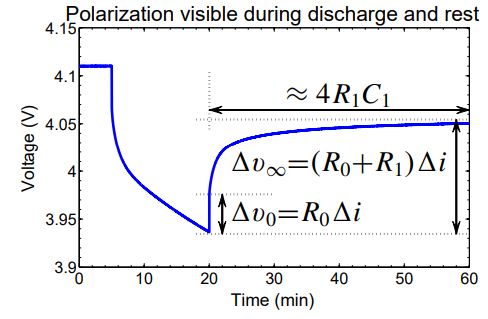

In [7]:
# create empty matrices to store the calculated values
R0_matrix = np.ndarray((3,8,4))
R1_matrix = np.ndarray((3,8,4))
C1_matrix = np.ndarray((3,8,4))

# calculate the values
R0_matrix = v_inst_changes / delta_curr
R1_matrix = v_settling_changes / delta_curr - R0_matrix
R1_matrix[0,7,3] = 0.1 # handle missing value
C1_matrix = t_settling_times /4 / R1_matrix
C1_matrix = np.round(C1_matrix,3)

In [8]:
C1_matrix

array([[[ 15.266,  19.578,  33.213,  77.551],
        [ 14.622,  21.084,  35.714,  82.975],
        [ 14.622,  21.084,  34.919,  86.279],
        [ 18.085,  24.616,  43.103,  90.693],
        [ 20.204,  24.995,  36.885,  76.919],
        [ 19.643,  23.541,  37.03 ,  74.07 ],
        [ 15.951,  21.048,  30.908,  42.969],
        [ 12.648,  15.83 ,  27.775,   9.625]],

       [[ 31.25 ,  32.5  ,  36.111,  53.125],
        [ 41.667,  25.   ,  27.778,  76.667],
        [ 20.833,  22.917,  30.556,  80.   ],
        [ 25.   ,  46.875,  35.714,  83.333],
        [ 31.25 ,  31.25 ,  66.667,  66.667],
        [ 31.25 ,  31.25 ,  50.   ,  57.692],
        [ 34.375,  34.375,  41.667,  69.231],
        [ 31.25 ,  31.25 ,  35.714,  68.75 ]],

       [[ 36.75 ,  39.27 ,  55.142, 112.397],
        [ 31.225,  32.051,  45.77 , 103.301],
        [ 32.712,  31.25 ,  45.77 ,  87.496],
        [ 31.225,  34.722,  54.156, 122.549],
        [ 45.815,  44.634,  61.315, 119.994],
        [ 49.107,  49.088,  50

In [9]:
C1_matrix.mean()

46.51083333333333

Save data

In [10]:
np.save(r"Results\r0.npy",R0_matrix)
np.save(r"Results\r1.npy",R1_matrix)
np.save(r"Results\c1.npy",C1_matrix)

#### 2. Explaining R0,R1,C1 Data matrices
- These are stored in 3 dimensional matrices ( Temperature- SOC- Current variance)
- Matrix indices are n,j,k
- n:  temperature index where 0-20-40 degrees correspond to 0,1,2
- j: SOC index where 90%-80%...-10% correspond to 0,1,2....,7
- k: current index where -2.5,-5,-10,-20 pulses correspond to 0,1,2,3

- Note: element 0,7,3 ( very last pulse at T=0 SOC equals 10% does not have data for the last pulse, so the corresponding values can be ignored)

NOTE- There is a problem with my method for finding the settling time, so the C1 values may be slightly unreliable will refine this

___________________________________
# Questions

- Here I run through the questions

## Part 2.A: Transient behaviour and current dependence

#### Part 2.A Questions

##### A. For the data at 20oC, identify the data corresponding to each individual pulse and fit these to your first order ECN model. (Hint: a first order ECN model uses one series resistor and one RC pair; therefore, it should be modelled using one exponent.)

- I have already done this for all Temperatures at Section 3 above

##### B. You should generate a table which has a value for R0, R1 and C1 for each SOC and for each discharging and charging currents used in the experimental parametrisation data.

- These data are already stored in R0_matrix, R1_Matrix, R2_matrix, shown below

In [11]:
print("R0 values at 20 degrees \n ", R0_matrix[1])
print("R1 values at 20 degrees \n ", R1_matrix[1])
print("C1 values at 20 degrees \n ", C1_matrix[1])

R0 values at 20 degrees 
  [[0.024  0.02   0.02   0.019 ]
 [0.02   0.02   0.02   0.0185]
 [0.02   0.018  0.019  0.0185]
 [0.02   0.02   0.02   0.019 ]
 [0.02   0.02   0.02   0.0195]
 [0.02   0.02   0.02   0.0195]
 [0.02   0.02   0.021  0.0205]
 [0.024  0.022  0.022  0.0225]]
R1 values at 20 degrees 
  [[0.008  0.01   0.009  0.008 ]
 [0.012  0.01   0.009  0.0075]
 [0.012  0.012  0.009  0.0075]
 [0.012  0.008  0.007  0.006 ]
 [0.008  0.008  0.006  0.006 ]
 [0.008  0.008  0.007  0.0065]
 [0.008  0.008  0.006  0.0065]
 [0.008  0.008  0.007  0.008 ]]
C1 values at 20 degrees 
  [[31.25  32.5   36.111 53.125]
 [41.667 25.    27.778 76.667]
 [20.833 22.917 30.556 80.   ]
 [25.    46.875 35.714 83.333]
 [31.25  31.25  66.667 66.667]
 [31.25  31.25  50.    57.692]
 [34.375 34.375 41.667 69.231]
 [31.25  31.25  35.714 68.75 ]]


##### C - You should be able to see that R0 does not depend on SOC and current magnitude in a meaningful manner – this is also what is expected from its physical interpretation. Thus, you may remove these dependencies. Take the average value for R0 at all currents and SOCs and put this back into your model as a constant (note R0 is a constant rather than a look up table). 

- R0 for T=20 is now a constant stored in the below variable

In [12]:
R0_T20 = R0_matrix[1].mean()
print("Mean value of R0 at 20 degrees: ", R0_T20)

Mean value of R0 at 20 degrees:  0.02021875


##### d. Similarly, take the average value for C1 at all currents and SOCs and put this back into your model as a constant.

- Our C values differ quite a bit but this is due to the impreicison of the way we calculate settling time, since there is no set criterion for this

In [13]:
C1_T20 = C1_matrix[1].mean()
print("Mean value of C1 at 20 degrees: ", C1_T20)

Mean value of C1 at 20 degrees:  43.186375


##### e. You now have only R1 dependent on SOC and current, and you will want to get a better fit for it - refit R1 to the same data used before, but now with the constant values of R0 (from c.) and C1 (from d.); from this refit, you obtain R1 as look-up table for various SOCs and current amplitudes. 

- I get different results for R1 when calculating with constant R0 and C1. Our R0 values are more reliable so I will trust the R1 calculated using that and store the results in R1_T20_matrix

In [14]:
# Get R1 from delta_v = (R1+R0) * delta_i   : R1 = delta_v/delta_i-R0
R1_T20_ConstantR0_array = v_settling_changes[1]/delta_curr[1] - R0_T20
R1_T20_ConstantR0 = R1_T20_ConstantR0_array.mean()
print("Mean R1 we get using constant R0 is : " , R1_T20_ConstantR0)

# Get R1 from t_settling = 4*R1*C1 : R1 = t_settling/4/C1
R1_T20_ConstantC1_array = t_settling_times[1]/4/C1_T20
R1_T20_ConstantC1 = R1_T20_ConstantC1_array.mean()
print("Mean R1 we get using constant C1 is : " , R1_T20_ConstantC1)


R1_T20_matrix = R1_T20_ConstantR0_array
R1_T20_matrix

Mean R1 we get using constant R0 is :  0.00825
Mean R1 we get using constant C1 is :  0.007814964789241978


array([[0.01178125, 0.00978125, 0.00878125, 0.00678125],
       [0.01178125, 0.00978125, 0.00878125, 0.00578125],
       [0.01178125, 0.00978125, 0.00778125, 0.00578125],
       [0.01178125, 0.00778125, 0.00678125, 0.00478125],
       [0.00778125, 0.00778125, 0.00578125, 0.00528125],
       [0.00778125, 0.00778125, 0.00678125, 0.00578125],
       [0.00778125, 0.00778125, 0.00678125, 0.00678125],
       [0.01178125, 0.00978125, 0.00878125, 0.01028125]])

##### f. Plot the value of R1 for 20C and 60% SOC against current and describe the shape. 
- R1 decreases with increasing current, and has an overall convex parabolical shape

In [15]:
# Create a function because we will need to do it again
def plot_R1_I(T, SOC, R1_matrix):
    plt.plot(delta_curr[T][SOC], R1_matrix[SOC],  'o', color='black')
    plt.plot(delta_curr[T][SOC], R1_matrix[SOC], color='red', linewidth=2)
    plt.xlabel("Current")
    plt.ylabel("R1")
    plt.title(f"R1 vs Current at T={T*20} degrees SOC = {90-10*SOC}%")
    plt.show()

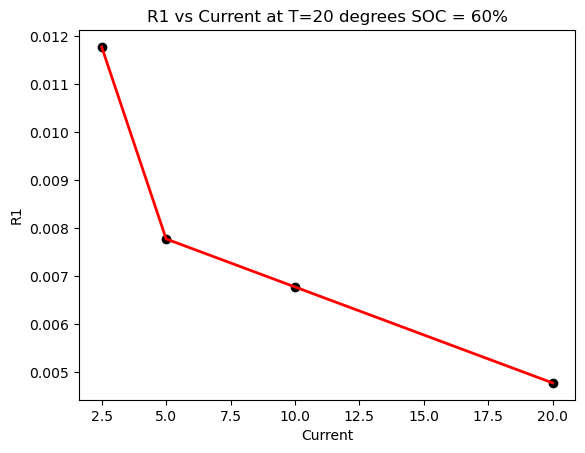

In [16]:
plot_R1_I(1,3,R1_T20_matrix)

##### G. The mathematical function that best represents the physics between R1 and current is a Gaussian function. Fit R1 for 20oC and 60% SOC to a first order Gaussian function as a function of current, and comment on the fit. 

In [17]:
def R1_Gaussian(I, R1_0, b, c, offset):
    return R1_0 * np.exp(-((I - b) ** 2) / c) + offset

# Function to plot R1 data for a given T and SOC, with Gaussian fitted with given parameters
def plot_R1_Gaussian(func,T,SOC,R1_matrix, params):
    curr_array = np.linspace(0,20,10)
    R1_array = func(curr_array, params[0], params[1], params[2], params[3])
    plt.plot(curr_array, R1_array, color='red', linewidth=2)

    plt.plot(delta_curr[T][SOC], R1_matrix[SOC],  'o', color='black')
    plt.xlabel("Current")
    plt.ylabel("R1")
    plt.title(f"R1 vs Current at T={T*20} degrees SOC = {90-10*SOC}% manually fitted Gaussian")



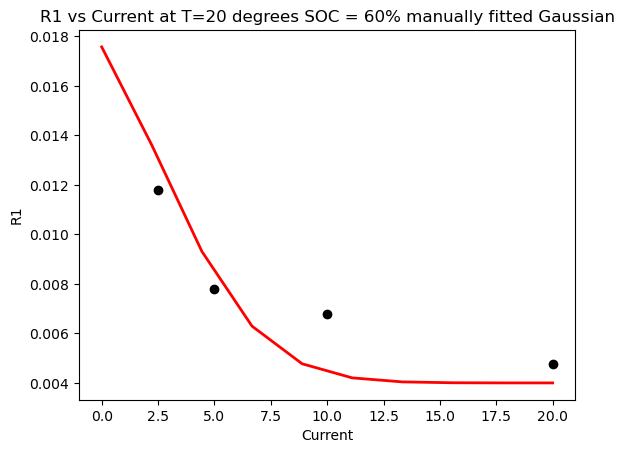

In [18]:
plot_R1_Gaussian(R1_Gaussian, 1,3,R1_T20_matrix, [0.015, -2, 40, 0.004])

##### h. Attempt to improve your fit for R1 by adjusting the fitted equation (this can be done by changing the order or applying an offset).

(Note – you may find that the pulses do not go to small enough currents to enable you to obtain a
Gaussian. You need to use the longer discharge periods, at low current to extract approximate R1
values for smaller currents in discharge.) 

In [19]:
# This function calculates and plots the best fit Gaussian line, given the data and initial parameters
def fit_R1_Gaussian(func,T,SOC, R1_matrix, p0 = [0.01, 1, 30, 0.004], 
                    bounds =( [-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf]) ):

    I = delta_curr[T][SOC].tolist()
    r1_vals = R1_matrix[SOC].tolist()
    p0 = [0.01, 1, 30, 0.004] # initial params
    params, pcov = curve_fit(func, I, r1_vals, p0=p0, maxfev=10000000, bounds = bounds)

    I_plotting = np.linspace(0,20,100)
    plt.plot(I, r1_vals, 'o', label='data')
    plt.plot(I_plotting, func(I_plotting, *params), label='fit')
    plt.xlabel("Current")
    plt.ylabel("R1")
    plt.title(f"R1 vs Current at T={T*20} degrees SOC = {90-10*SOC}% fitted with a Gaussian")
    plt.legend()
    plt.show()
    print('R1_0:', params[0])
    print('b:', params[1])
    print('c:', params[2])
    print("offset", params[3])

    return params

c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


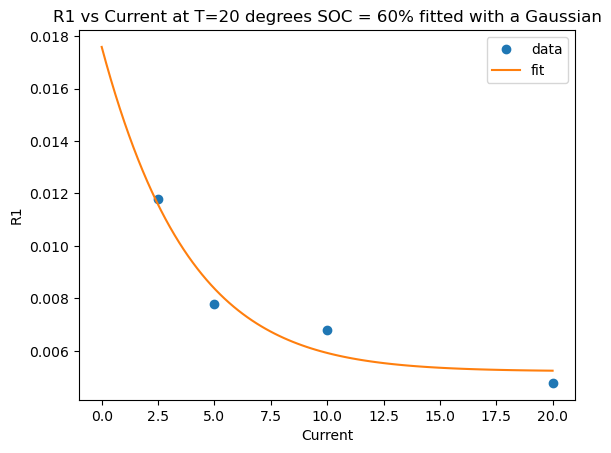

R1_0: 4.999197563389643
b: -46.305477491104675
c: 357.21386541916235
offset 0.005224627217338905


In [20]:
R1_T20_Gaussian_params = fit_R1_Gaussian(R1_Gaussian, 1,3, R1_T20_matrix, p0 = [0.15, -2, 40, 0.04]
                                         , bounds = ([-5, -np.inf, -np.inf, -np.inf], [5, np.inf, np.inf, np.inf]) )

#### Part 2.A Discussion

1. Comment on the advantages and disadvantages of the three approaches to the interpolation
problem described above, and any other approaches of which you can think. 


2. What assumptions about the physical mechanisms inside a battery are you making by keeping R0 constant?

3. Plot the value of R0 as a function of current at 60% SOC and comment on how accurate this
assumption is.

Text(0.5, 1.0, 'R0 vs Current at T=20degrees SOC = 60%')

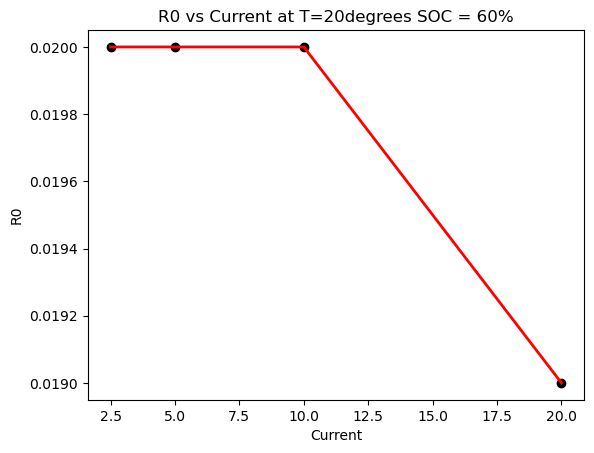

In [21]:
# Plot the point
r0_plot = r0_20_60 = R0_matrix[1][3]
current_plot = delta_curr[1][3]
plt.plot(current_plot, r0_plot,  'o', color='black')


# Also plot a fitted line
coefficients = np.polyfit(current_plot,r0_plot,3)
line = np.polyval(coefficients, current_plot)

plt.plot(delta_curr[0][3], line, color='red', linewidth=2)

plt.xlabel("Current")
plt.ylabel("R0")
plt.grid
plt.title("R0 vs Current at T=20degrees SOC = 60%")


The assumption of constant R0 with current seems reasonablly accurate. We see that when current increases by a lot to 20A our resistance drops by 0.001. This may be due to calculation erros as well though.

4. What assumptions regarding battery mechanisms are you making by keeping C1 constant? 

5. Plot the value of C1 as a function of current at 60% SOC and comment on how accurate this
assumption is. 

Text(0.5, 1.0, 'R0 vs Current at T=20degrees SOC = 60%')

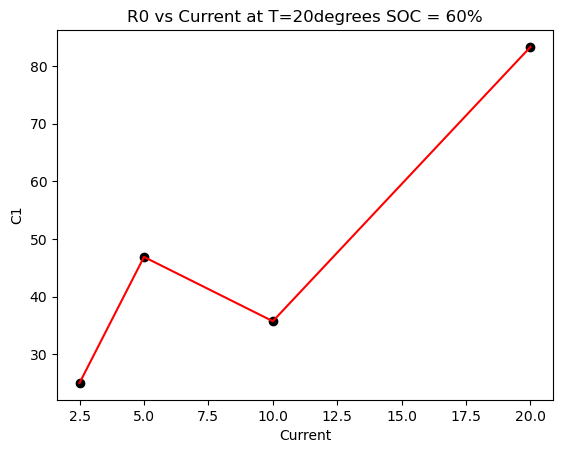

In [22]:
# Plot the point
c1_plot = c1_20_60 = C1_matrix[1][3]
current_plot = delta_curr[1][3]
plt.plot(current_plot, c1_plot,  'o', color='black')
plt.plot(current_plot, c1_plot,   color='red')

plt.xlabel("Current")
plt.ylabel("C1")
plt.grid
plt.title("R0 vs Current at T=20degrees SOC = 60%")


The plot would suggest our assumption of constant C1 is not accurate. It is more likely that our C1 values are incorrect because the calculation of settling time is very arbitary.

## Part 2B: Temperature Dependence of R0

#### Part 2B Questions

##### A. Repeat steps a-g from part 2a for the data given at 0oC and 40oC, but  using the value of C1 at 20oC as a constant throughout. 


Steps A,B already done
Steps C,D,E done below

In [23]:
# A,B : Done

# C. Take average values of R0
# T=0
R0_T0 = R0_matrix[0].mean()
print("Mean value of R0 at 0 degrees: ", R0_T0)
# T=40
R0_T40 = R0_matrix[2].mean()
print("Mean value of R0 at 40 degrees: ", R0_T40)

# D. Use the C1 value from before
C1_T0 = C1_T20
C1_T40 = C1_T20
C1 = C1_T20 


# E.

# Calculate R1 using constant R0
# T=0
R1_T0_ConstantR0_array = v_settling_changes[0]/delta_curr[0] - R0_T0
R1_T0_ConstantR0 = R1_T0_ConstantR0_array.mean()
print("Mean R1 we get using constant R0 for T = 0 is : " , R1_T0_ConstantR0)

# T=40
R1_T40_ConstantR0_array = v_settling_changes[2]/delta_curr[2] - R0_T40
R1_T40_ConstantR0 = R1_T40_ConstantR0_array.mean()
print("Mean R1 we get using constant R0 for T = 40 is : " , R1_T40_ConstantR0)


# Calculate R1 using constant C1
# T=0
R1_T0_ConstantC1_array = t_settling_times[0]/4/C1_T0
R1_T0_ConstantC1 = R1_T0_ConstantC1_array.mean()
print("Mean R1 we get using constant C1 at T=0  is : " , R1_T0_ConstantC1)

# T=40 
R1_T40_ConstantC1_array = t_settling_times[2]/4/C1_T40
R1_T40_ConstantC1 = R1_T40_ConstantC1_array.mean()
print("Mean R1 we get using constant C1 at T=40 is : " , R1_T40_ConstantC1)

# Continue with the values calculated from R0 rather than C1
 
R1_T0_matrix = R1_T0_ConstantR0_array
R1_T40_matrix =  R1_T40_ConstantR0_array

Mean value of R0 at 0 degrees:  0.04003191858269506
Mean value of R0 at 40 degrees:  0.015232532035267449
Mean R1 we get using constant R0 for T = 0 is :  0.01629269436141781
Mean R1 we get using constant R0 for T = 40 is :  0.006187216620631231
Mean R1 we get using constant C1 at T=0  is :  0.012446055034718705
Mean R1 we get using constant C1 at T=40 is :  0.008339580481112389


##### A-F. Plotting R1 against current at SOC 60% 

At T=0

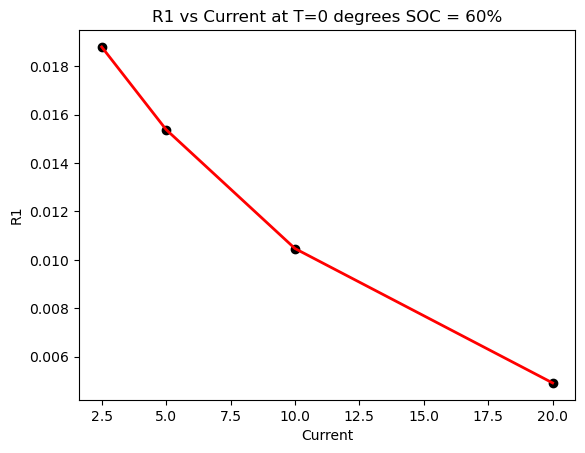

In [24]:
plot_R1_I(0, 3, R1_T0_matrix)

At T=40

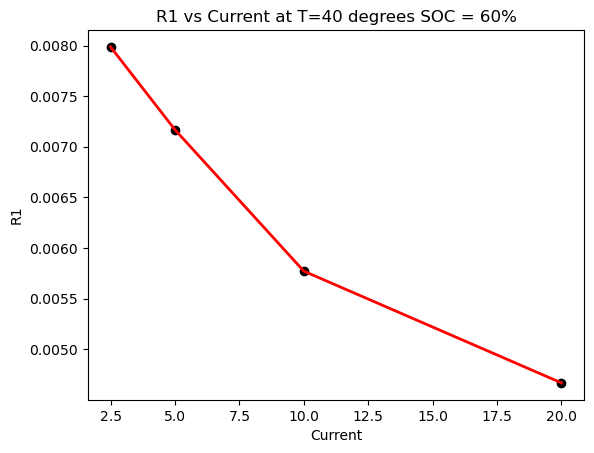

In [25]:
plot_R1_I(2, 3, R1_T40_matrix)

##### A-G. Plot the Gaussian by manually fitting the parameters

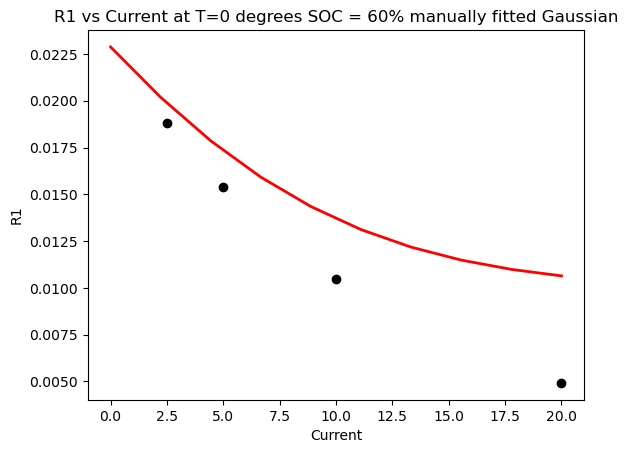

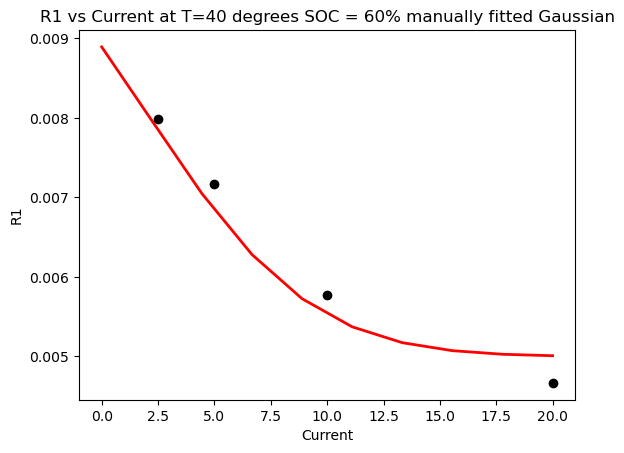

In [26]:
plot_R1_Gaussian(R1_Gaussian, 0,3,R1_T0_matrix, [ 0.035, -20, 400, 0.01 ])
plt.show()
plot_R1_Gaussian(R1_Gaussian, 2,3,R1_T40_matrix, [ 0.005, -5, 100, 0.005])
plt.show()

##### A-H. Fit the Gaussian properly using curve fitting

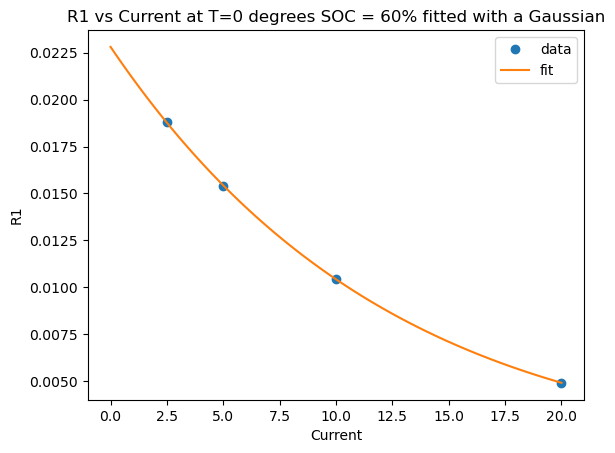

R1_0: 4.898907570001796
b: -132.1153826373703
c: 3216.6949473928125
offset 0.0012459295490344683


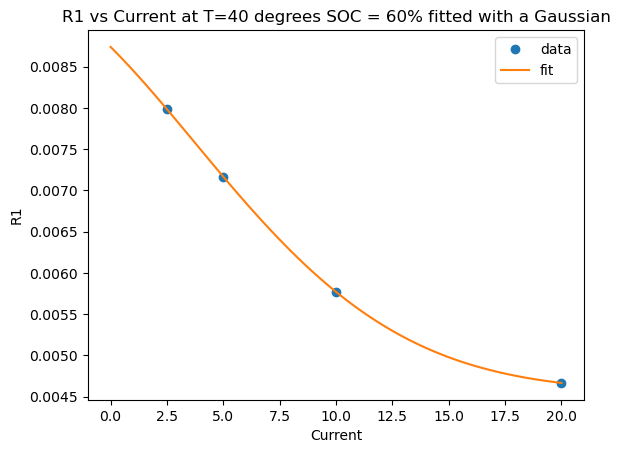

R1_0: 0.005000252425152799
b: -5.511417200788315
c: 169.7625643453073
offset 0.004559324021569922


In [27]:
fit_R1_Gaussian(R1_Gaussian, 0,3, R1_T0_matrix, p0 = [ 0.035, -20, 400, 0.01 ],
                bounds = ([-5, -np.inf, -np.inf, -np.inf], [5, np.inf, np.inf, np.inf]))
plt.show()
fit_R1_Gaussian(R1_Gaussian, 2,3, R1_T40_matrix, p0 = [0.15, 3, 40, 0.04],
                bounds = ([-5, -np.inf, -np.inf, -np.inf], [5, np.inf, np.inf, np.inf]))
plt.show()

##### B.Plot the value of R0 (averaged over current) as a function of temperature at 60% SOC and describe its shape. 

Text(0.5, 1.0, 'R0 vs Temperature at SOC = 60%')

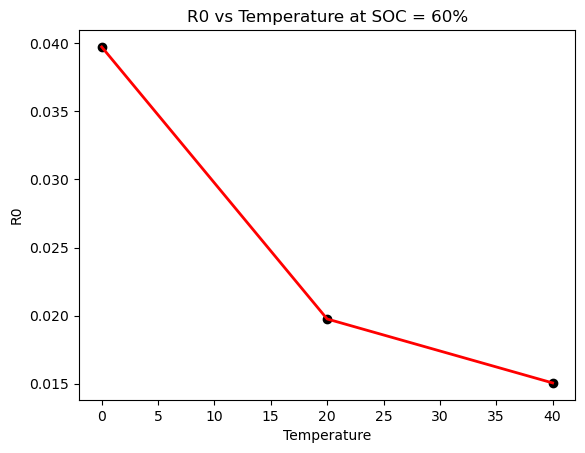

In [28]:
# Get average R0 values at 60% SOC for each temperature
R0_averaged = [R0_matrix[0][3].mean(), R0_matrix[1][3].mean(),  R0_matrix[2][3].mean()]

# Plot points and a line
plt.plot([0,20,40], R0_averaged, 'o', color='black')
plt.plot([0,20,40], R0_averaged, color='red', linewidth=2)
plt.xlabel("Temperature")
plt.ylabel("R0")
plt.title("R0 vs Temperature at SOC = 60%")

- R0 decreases with increasing Tempearture

##### C. Fit the R0 from (b) above to the Arrhenius equation as a function of temperature

In [29]:
# define arrhenius function
# note that R0_averaged[1] is the R0 value at 20 degrees i.e. a constant
def R0_Arrhenius(T,E, scale_offset, offset):
    R_gas = 8.3144598
    return  scale_offset * R0_averaged[1]* np.exp((-E/R_gas)*(1/(T+273.15) - 1/293.15)) + offset

# Function to fit Arrgenius curve - input the parameter and SOC name as well 
def fit_Arrhenius(func,R_vals,param_name,SOC, p0 = [ -1,-1,1], bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])):

    params, pcov = curve_fit(func,[0,20,40], R_vals, p0=p0, maxfev=10000000, bounds = bounds)

    T_plotting = np.linspace(0,40,100)
    plt.plot([0,20,40], R_vals, 'o', label='data')
    plt.plot(T_plotting, func(T_plotting, *params), label='fit')
    plt.xlabel("Temperature")
    plt.ylabel(f"{param_name}")
    plt.title(f"{param_name} vs Temperature at SOC = {SOC}%")

    # print the optimal parameters
    print("E: ", params[0])
    print("Scaling factor: ", params[1])
    print("Offset:", params[2])


    return params

E:  -45975.59727589755
Scaling factor:  0.3395828590166068
Offset: 0.013043238534422017


array([-4.59755973e+04,  3.39582859e-01,  1.30432385e-02])

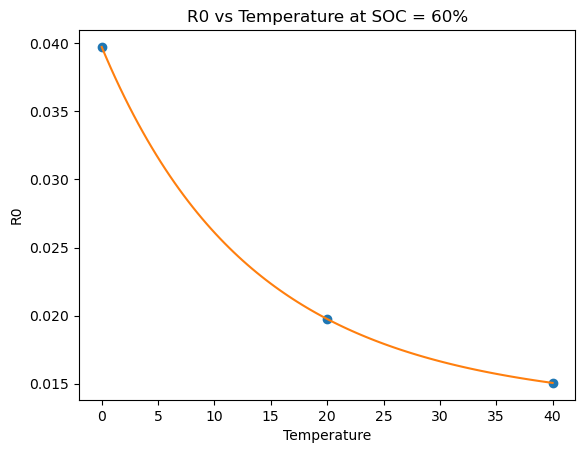

In [30]:
R0_Arrhenius_Params = fit_Arrhenius(R0_Arrhenius,R0_averaged,"R0","60",p0 = [ 2000,1,0])
R0_Arrhenius_Params

##### 2.B Discussion
1. How much does R0 vary with temperature?
- Decreases with increasing temperature

2. What physical process does R0 represent?
- Electrolyte resistance

3. Explain why R0 varies in this way with temperature




### Part 2.C : Temperature Dependance of R1
Parametrisation : R1 is a function of current, temperature and SOC



##### A. Plot the value for R1 at 0°C and -2.5A as a function of SOC

Text(0.5, 1.0, 'R1 vs SOC at T=0')

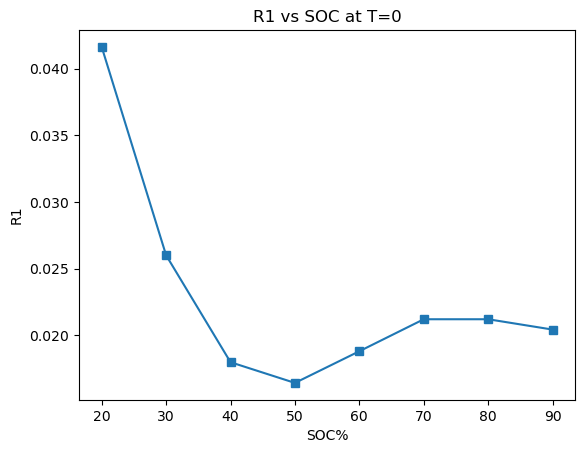

In [31]:
socs = np.linspace(90,20,8)
plt.plot(socs, R1_T0_matrix[:,0], marker= "s") # select the first column of the matrix
plt.xlabel("SOC%")
plt.ylabel("R1")
plt.title("R1 vs SOC at T=0")

##### B. Comment on R1 dependency on SOC 

R1 increases with decreasing SOC after about SOC = 40, before that it is roughly constant, our data is noisy so its fluctuating a little.

For simplicity, from here on, you will ignore the R1 dependence on SOC. To continue parametrising your model, complete the following steps:

##### C. Plot the value of R1 at 60% SOC and -2.5A as a function of temperature. 

Text(0.5, 1.0, 'R1 vs T at SOC=60%')

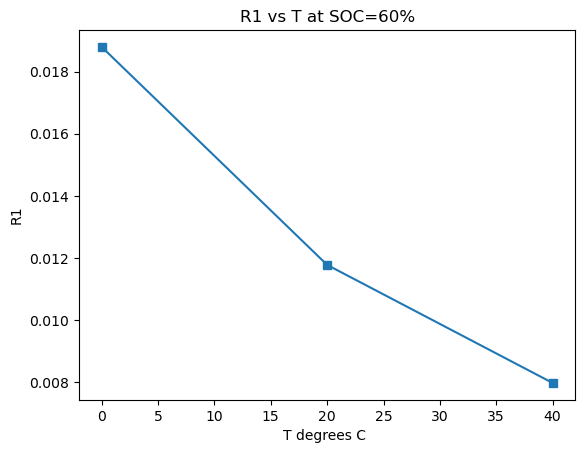

In [32]:
temps = np.linspace(0,40,3) # x axis of temperatures 
# Get R1 values at SOC=60% I = -2.5 for each temperature : index [3,0]
r_vals = [R1_T0_matrix[3,0], R1_T20_matrix[3,0], R1_T40_matrix[3,0]]

plt.plot(temps, r_vals, marker= "s")
plt.xlabel("T degrees C ")
plt.ylabel("R1")
plt.title("R1 vs T at SOC=60%")

d. For the data plotted in c., fit R1 to the Arrhenius equation to obtain R1 as a function of
temperature. 

In [33]:
def R1_Arrhenius(T,E, scale_offset, offset):
    R_gas = 8.3144598
    # R1_T20_matrix[3,0] is a constant, R1 value at 20 degrees, I = -2.5, SOC = 60%
    return  scale_offset * R1_T20_matrix[3,0]* np.exp((-E/R_gas)*(1/(T+273.15) - 1/293.15)) + offset


E:  -16870.89498695852
Scaling factor:  0.9016047099906098
Offset: 0.0011592195104231289


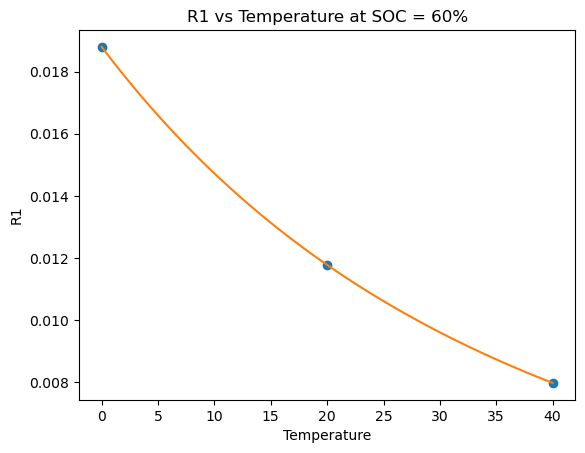

In [34]:
# store fitted E value for later use
R1_Arrhenius_params = fit_Arrhenius(R1_Arrhenius,r_vals,"R1","60", p0 = [ 2000,1,0])

##### E. Plot the value of R1 at -2.5A as a function of temperature, at 30% SOC and 90% separately

##### F. On each of the two plots in e., overlay the Arrhenius equation using the values of R1 20oC for that SOC, and the value of E as parametrised at 60%.

SOC=90%

Text(0.5, 1.0, 'R1 vs T at SOC=90%')

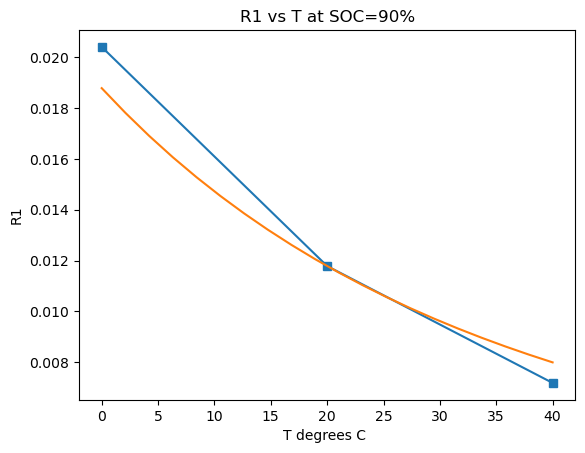

In [35]:
# Get R1 values at SOC=90% I = -2.5 for each temperature
r_vals = [R1_T0_matrix[0,0], R1_T20_matrix[0,0], R1_T40_matrix[0,0]]
plt.plot([0,20,40], r_vals, marker= "s", label="Real data")

# Plot the fitted lien using arrhenius and the E value found above
temps = np.linspace(0,40,20)
r_vals_predicted = R1_Arrhenius(temps, *R1_Arrhenius_params)
plt.plot(temps, r_vals_predicted, label= "Fitted line in Arrhenius")
plt.xlabel("T degrees C ")
plt.ylabel("R1")
plt.title("R1 vs T at SOC=90%")

SOC= 30%

Text(0.5, 1.0, 'R1 vs T at SOC=30%')

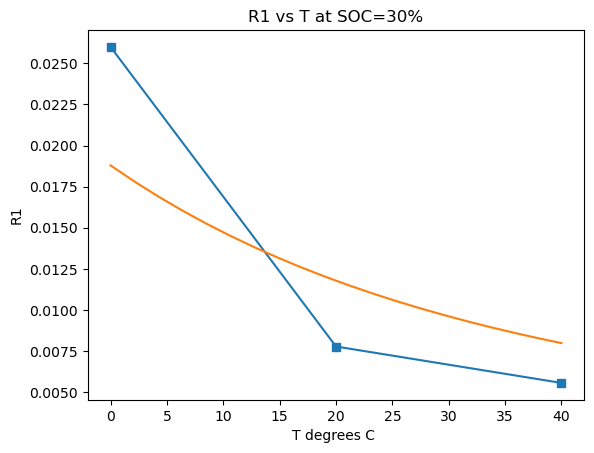

In [36]:
# Get R1 values at SOC=30% I = -2.5 for each temperature
r_vals = [R1_T0_matrix[6,0], R1_T20_matrix[6,0], R1_T40_matrix[6,0]]
plt.plot( [0,20,40], r_vals, marker= "s", label="Real data")

# Plot the fitted lien using arrhenius and the E value found above
temps = np.linspace(0,40,20)
r_vals_predicted = R1_Arrhenius(temps, *R1_Arrhenius_params)
plt.plot(temps, r_vals_predicted, label= "Fitted line in Arrhenius")
plt.xlabel("T degrees C ")
plt.ylabel("R1")
plt.title("R1 vs T at SOC=30%")


##### Discussion
1. Discuss how accurate the Arrhenius equation with the same exponential factor is at predicting the behaviour of R1 at different SOCs.

- The same exponential factor does not fit the R1s at different SOCs very well, it visibly underestimates R1 at SOC=30%. We can get a much more accurate fit if we get the E value for each SOC as such:

E:  -17401.79908229832
Scaling factor:  1.067413441622033
Offset: -0.0007942146091095776


Text(0.5, 1.0, 'R1 vs Temp at SOC=90% - with E values fitted for SOC = 90%')

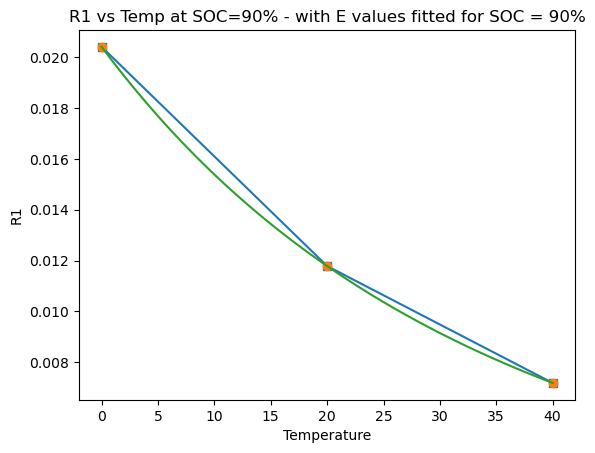

In [37]:
# Get R1 values at SOC=90% I = -2.5 for each temperature
r_vals = [R1_T0_matrix[0,0], R1_T20_matrix[0,0], R1_T40_matrix[0,0]]
plt.plot([0,20,40], r_vals, marker= "s")

fit_Arrhenius(R1_Arrhenius,r_vals,"R1","90", p0 = [ 2000,1,0])

plt.title("R1 vs Temp at SOC=90% - with E values fitted for SOC = 90%")

E:  -68659.44030120582
Scaling factor:  0.22515958578351433
Offset: 0.005128588629987975


Text(0.5, 1.0, 'R1 vs Temp at SOC=30% - with E values fitted for SOC = 30%')

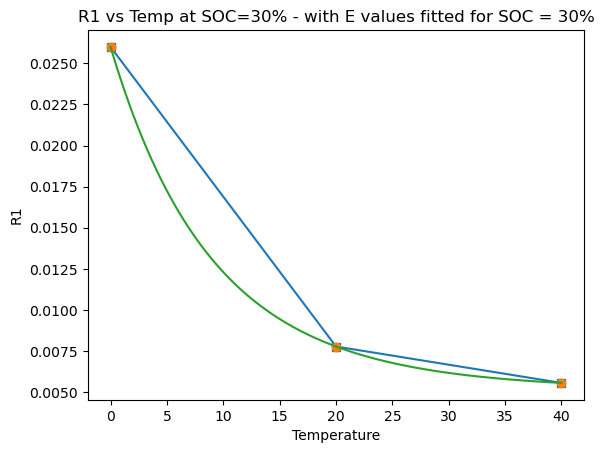

In [38]:
# Get R1 values at SOC=30% I = -2.5 for each temperature
r_vals = [R1_T0_matrix[6,0], R1_T20_matrix[6,0], R1_T40_matrix[6,0]]
plt.plot( [0,20,40], r_vals, marker= "s")

fit_Arrhenius(R1_Arrhenius,r_vals,"R1","90", p0 = [ 2000,1,0])
plt.title("R1 vs Temp at SOC=30% - with E values fitted for SOC = 30%")

So in the model we can use the Arrhenius for R0 fitted for each SOC, as a function of temperature. Below I calculate all the optimal parameters

E:  -17401.79908229832
Scaling factor:  1.067413441622033
Offset: -0.0007942146091095776
E:  -31093.272977519
Scaling factor:  0.5171144090675066
Offset: 0.005688995868173437
E:  -31093.272977519
Scaling factor:  0.5171144090675066
Offset: 0.005688995868173437
E:  -16870.89498695852
Scaling factor:  0.9016047099906098
Offset: 0.0011592195104231289
E:  -43083.48076950611
Scaling factor:  0.27667093517782415
Offset: 0.0045217205449362636
E:  -48683.310183903595
Scaling factor:  0.26070981435471674
Offset: 0.004709762499633497
E:  -68659.44030120582
Scaling factor:  0.22515958578351433
Offset: 0.005128588629987975
E:  -54978.59305038321
Scaling factor:  0.6011283466082797
Offset: 0.004699206666521205


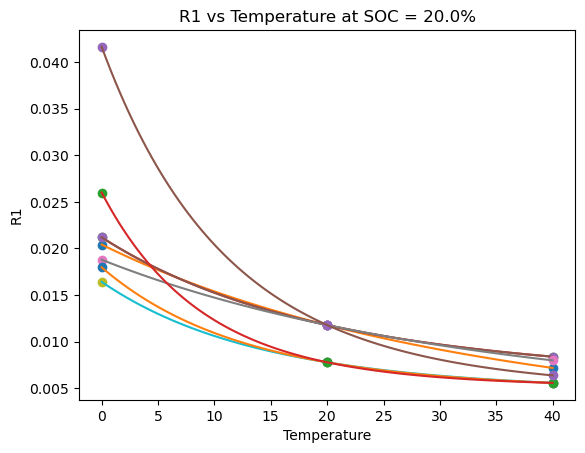

In [39]:
r_vals = np.array([R1_T0_matrix[:,0], R1_T20_matrix[:,0], R1_T40_matrix[:,0]])
temps = np.linspace(0,40,20)
R1_Arrhenius_Params_Matrix = np.ndarray((8,3))
for i in range(8):
    r_vals_current = r_vals[:,i] # get the R1 values for each SOC
    # fit the arrhenius r1
    R1_Arrhenius_Params_Matrix[0,:] = fit_Arrhenius(R1_Arrhenius,r_vals_current,"R1",socs[i], p0 = [ 2000,1,0])



2. Do you think the temperature dependence of C1 is needed for the model to be accurate? 
- I'm not sure how to answer this YET

#### Parametrisation
You can now combine these functions to create a new function for R1 that includes both the current
and temperature dependence: 

Define the function with all 5 parameters

In [40]:
def new_R1_equation(x, R1_0A_T20, b, c, E, offset): # this takes R1 value at 0amps and T20
    I, T = x.reshape((2, -1))
    R_gas = 8.3144598
    return R1_0A_T20 * np.exp(-((I-b)**2)/c) * np.exp((-E/R_gas)*(1/(T+273.15) - 1/293.15)) + offset

Create the arrays for the current and temperature, and the real R1 values to fit

In [41]:
R1_T_I_matrix = np.array([R1_T0_matrix.mean(axis=0), 
                 R1_T20_matrix.mean(axis=0), 
                 R1_T40_matrix.mean(axis=0)])

T_matrix = np.array([[0,0,0,0],
               [20,20,20,20],
               [40,40,40,40]])

I_matrix = np.array([[2.5,5,10,20],
                    [2.5,5,10,20],
                    [2.5,5,10,20]])


# Reshape R1_T_I_matrix to a flattened array
ydata = R1_T_I_matrix.flatten()

# Reshape I_matrix and T_matrix to a flattened array
xdata = np.array([I_matrix.flatten(), T_matrix.flatten()])



In [42]:
xdata.shape

(2, 12)

Fit the function parameters

In [43]:
# Create the initial guess for the parameters
p0 = [0.01, 1, 30, 1,0]


# Fit the function to the data
params, pcov = curve_fit(new_R1_equation, xdata, ydata, p0=p0)

R1_Gaussian_params = params

# Print the fitted parameters
print("R1_0A_T20 = ", params[0])
print("b = ", params[1])
print("c = ", params[2])
print("E = ", params[3])
print("Offset = ", params[4])


R1_0A_T20 =  0.005331633425319454
b =  -3.782478258939924
c =  240.68475166821952
E =  -45115.712398837124
Offset =  0.005350409767917338


Predict R1 using our equation

In [44]:
R1_T_I_predicted_matrix  = new_R1_equation(xdata,*params).reshape((3,4))
R1_T_I_predicted_matrix

array([[0.02289877, 0.02035686, 0.01474106, 0.00732224],
       [0.00987564, 0.00922016, 0.007772  , 0.00585889],
       [0.0067379 , 0.00653692, 0.0060929 , 0.00550632]])

Plot R against I for each temperature

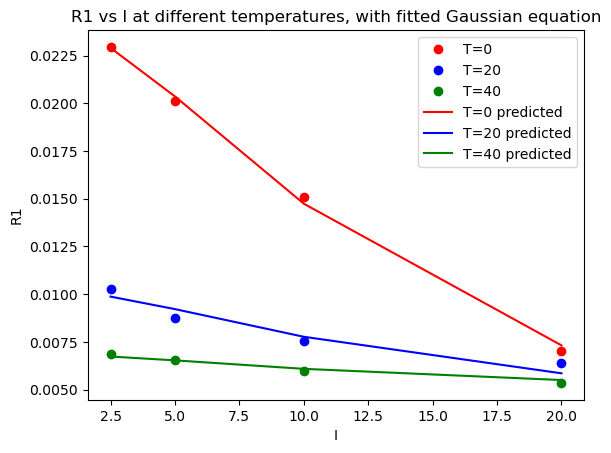

In [45]:
# Plot Real R1 values
plt.plot(I_matrix[0,:], R1_T_I_matrix[0,:],"o", c="r",label="T=0")
plt.plot(I_matrix[1,:], R1_T_I_matrix[1,:], "o", c="b",label="T=20")
plt.plot(I_matrix[2,:], R1_T_I_matrix[2,:], "o", c="g",label="T=40")

# Plot fitted curves
plt.plot(I_matrix[0,:], R1_T_I_predicted_matrix[0,:], c="r", label="T=0 predicted")
plt.plot(I_matrix[1,:], R1_T_I_predicted_matrix[1,:], c="b",label="T=20 predicted")
plt.plot(I_matrix[2,:], R1_T_I_predicted_matrix[2,:],  c="g",label="T=40 predicted")

plt.xlabel("I")
plt.ylabel("R1")
plt.title("R1 vs I at different temperatures, with fitted Gaussian equation")
plt.legend()


#### So to summarise
- I have R0 as a function of temperature: 
        - R0_Arrhenius(T,E), E is stored in R0_Arrhenius_params
- I have R1 as a function of current and temperature
        - new_R1_equation(x, R1_0A_T20, b, c, E) : x is a 2,12 matrix of Current and Temperatures, parameters are stored in  R1_Gaussian_Params
- I have C1 as a constant
        - Stored in  C1_T0,C1_T20,C1_T40 : all are the same
 

In [46]:
R0_Arrhenius_Params

array([-4.59755973e+04,  3.39582859e-01,  1.30432385e-02])

### Part 2.D : Implementation


In [47]:
df_test = pd.read_csv("Data\Battery_Testing_Data.csv")
ocv_data = pd.read_csv("Data\SOC_OCV_MFCTT_2019.csv",sep = "\t")

# convert current to miliamps and start fom t=1
Current = np.array(df_test["Current (mA)"][1:].reset_index(drop=True))/1000
Voltage = np.array(df_test["Voltage (V)"][1:].reset_index(drop=True))
Temp = np.array(df_test["Temperature"][1:].reset_index(drop=True))
Time = np.array(df_test["Time (s)"][1:].reset_index(drop=True))


df_test.head()


,Time (s),Current (mA),Voltage (V),Temperature
0,NaN,NaN,NaN,NaN
1,1.0,0.0,4.05,21.96
2,2.0,0.0,4.05,21.94
3,3.0,0.0,4.05,21.94
4,4.0,0.0,4.05,21.93


##### Model

Potential error sources:
- C1 is not accurately calculated
- I may have messed up the sign that the current takes in some functions


In [48]:
Temp

array([21.96, 21.94, 21.94, ..., 20.13, 20.13, 20.13])

In [49]:
def my_model(df_test,df_ocv,R0_func, R0_Params, R1_func, R1_Params, C1):
    # Set parameters and datasets
    
    Current = np.array(df_test["Current (mA)"][1:].reset_index(drop=True))/1000
    Voltage = np.array(df_test["Voltage (V)"][1:].reset_index(drop=True))
    Temp = np.array(df_test["Temperature"][1:].reset_index(drop=True))
    Time = np.array(df_test["Time (s)"][1:].reset_index(drop=True))

    R0_func = R0_func
    R1_func = R1_func
    R0_Params = R0_Params
    R1_Params = R1_Params
    C = C1



    n = len(Current) # size of all our arrays

    dt = Time[1] - Time[0] # our timestep

    # Calculate R0
    R0 = R0_func(Temp, *R0_Params)

    # Calculate R1
    xdata = np.array([Current, Temp])
    R1 = np.array(R1_func(xdata, *R1_Params))
    #R1 = np.floor(R1/0.001) * 0.001

    # Calculate current through R1 using formula in the slides
    Current_R1 = np.zeros(n)

    for i in range(n-1):
        Current_R1[i+1] = np.exp(-dt/(R1[i]*C)) * Current_R1[i] + (1-np.exp(-dt/(R1[i]*C))) * Current[i]


    # Calculate state of charge (called z for consistency)
    z_start = 86
    z = np.zeros(n)
    z[0] = z_start
    for i in range(n-1):
        z[i+1] = z[i] + Current[i]*dt/(2.5*60*60)*100

    z = np.round(z,2)

    # Calculate OCV by interpolating from the OCV data
    # drop duplicates so interpolation works
    duplicates = df_ocv.duplicated(subset=['SOC'])
    df_ocv = df_ocv.drop_duplicates(subset=['SOC'])


    ocv_interpolation = interp1d(df_ocv['SOC'], df_ocv['Ecell/V'], kind='cubic')
    ocv = ocv_interpolation(z)

    # Calculate voltage #v(t) = OCV(z(t)) - R1 * i_r1(t) - R0 * i(t)
    # my currents are negative I think so I set these to +
    v_model = ocv + R1 * Current_R1 + R0 * Current

    
    return v_model
    


def plot_model(v_model,df_test, start_time = 1, end_time = 23431):


    Time = np.array(df_test["Time (s)"][1:].reset_index(drop=True))
    Voltage = np.array(df_test["Voltage (V)"][1:].reset_index(drop=True))

    start_index = np.where(Time == start_time)[0][0]
    end_index = np.where(Time == end_time)[0][0]

    # Plot the Voltage time graph from original data
    ax, fig = plt.subplots( figsize=(12, 6))
    plt.plot(Time[start_index:end_index], Voltage[start_index:end_index], label="Voltage Original Test Data")
    plt.plot(Time[start_index:end_index], v_model[start_index:end_index], label="Voltage Predicted by Model")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    plt.title("Voltage vs Time")
    plt.legend()
    plt.show()




def plot_model_errors(v_model,df_test, start_time = 1, end_time = 23431):

    Time = np.array(df_test["Time (s)"][1:].reset_index(drop=True))
    Voltage = np.array(df_test["Voltage (V)"][1:].reset_index(drop=True))

    start_index = np.where(Time == start_time)[0][0]
    end_index = np.where(Time == end_time)[0][0]


    v_error = Voltage - v_model
    fig, ax = plt.subplots(2,1, figsize=(12, 6))
    ax[0].plot(Time, v_error, label="Absolute Voltage Error ")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Voltage Error (V)")
    ax[0].set_title("Voltage Error vs Time (V)")
    ax[0].legend()
    


    v_error_percentage = (Voltage - v_model)/Voltage*100
    ax[1].plot(Time, v_error_percentage, label="% Voltage Error")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Voltage Error %")
    ax[1].set_title("Voltage Error vs Time %")
    ax[1].legend()
    fig.subplots_adjust(hspace=0.4)

# I want to see how the error changes with C 
def calc_errors(v_model,df_test, C1, start_time = 1, end_time = 23431):
    Voltage = np.array(df_test["Voltage (V)"][1:].reset_index(drop=True))
    mse = np.sum((v_model - Voltage)**2) / len(v_model)
    max_error = np.max(np.abs ( (v_model - Voltage)**2))
    print("For C = {} MSE:{} Max error: {} ".format(C1, mse, max_error ))


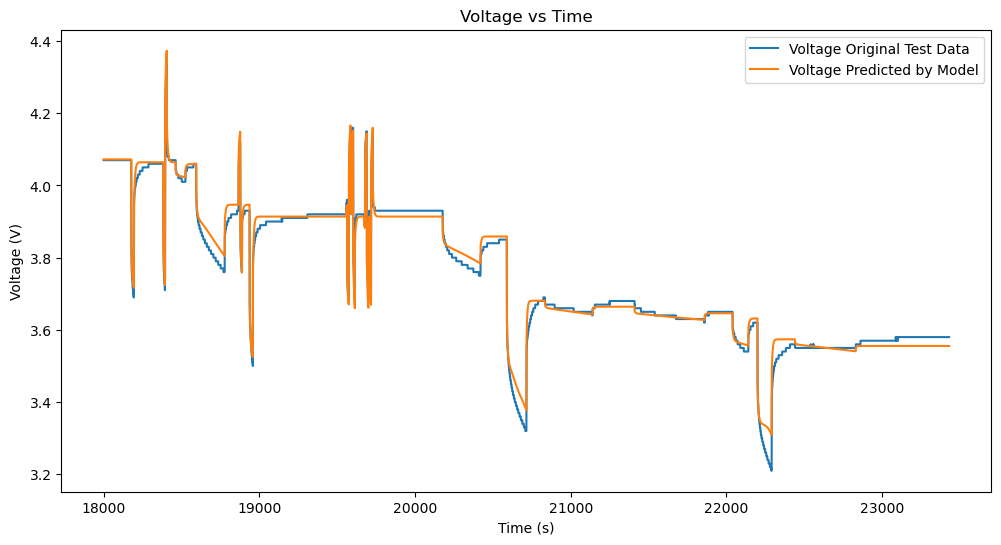

For C = 600 MSE:0.000203344561222652 Max error: 0.015432055452412007 


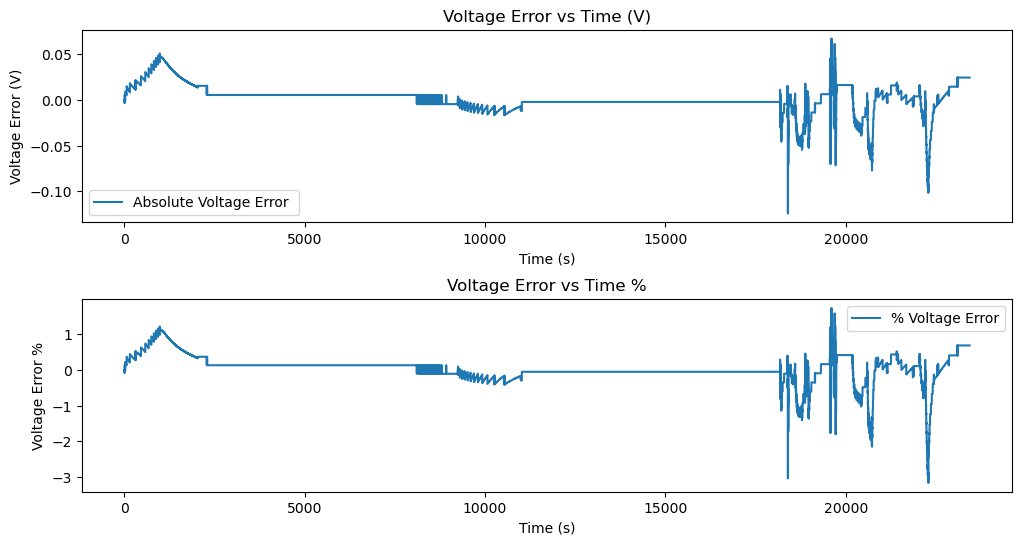

In [50]:
C1 = C1_T0
C1 = 600
v_model = my_model(df_test,ocv_data,R0_Arrhenius, R0_Arrhenius_Params, new_R1_equation, R1_Gaussian_params, C1)
plot_model(v_model,df_test, start_time = 18000, end_time = Time.max())
plot_model_errors(v_model,df_test, start_time = 18000, end_time = Time.max())
calc_errors(v_model,df_test, C1)

In [51]:
# Capacitance seems to be best taken as ~500

In [52]:
for i in range(1,2000,100):
    temp_model =  my_model(df_test,ocv_data,R0_Arrhenius, R0_Arrhenius_Params, new_R1_equation, R1_Gaussian_params, i)
    calc_errors(temp_model,df_test, i)


For C = 1 MSE:0.0002428126932364904 Max error: 0.025328199742096203 
For C = 101 MSE:0.0002339904538065726 Max error: 0.01704590529736953 
For C = 201 MSE:0.00022353287798807748 Max error: 0.013633285960694217 
For C = 301 MSE:0.00021587313764921047 Max error: 0.013144305151652325 
For C = 401 MSE:0.00021031565926919862 Max error: 0.013730258823339607 
For C = 501 MSE:0.0002062717158590321 Max error: 0.014529891179294513 
For C = 601 MSE:0.0002033194155775014 Max error: 0.015441467221320332 
For C = 701 MSE:0.0002011732702649303 Max error: 0.016394300435221297 
For C = 801 MSE:0.00019963865355947488 Max error: 0.017345287929037854 
For C = 901 MSE:0.0001985788103814913 Max error: 0.018269829249585322 
For C = 1001 MSE:0.0001978945622151221 Max error: 0.019154812985463867 
For C = 1101 MSE:0.00019751205707794909 Max error: 0.019994059574502 
For C = 1201 MSE:0.00019737513849193367 Max error: 0.020785500345658826 
For C = 1301 MSE:0.00019744037742929046 Max error: 0.02152945566577008 
Fo

# Part 3

In [131]:
def part3_model(df_test,df_ocv,R0_func, R0_Params, R1_func, R1_Params, C1, Tambient, h_value):
    # Get current and time arrays
    Current = np.array(df_test["Current (mA)"][1:].reset_index(drop=True))/1000
    Time = np.array(df_test["Time (s)"][1:].reset_index(drop=True))

    # Set up functions and parameters for R0 and R1, and set our C1 value
    R0_func = R0_func
    R1_func = R1_func
    R0_Params = R0_Params
    R1_Params = R1_Params
    C = C1
    n = len(Current) # size of all our arrays
    dt = Time[1] - Time[0] # our timestep


    # Define cell parameters
    m = 0.05
    r = ((18.33)/1000)/2
    height = 64.85/1000
    Area= (np.pi * r**2)*2 + height*2*np.pi*r
    Cp = 825 # specific heat
    Tamb =  Tambient# !! This should be in celsius
    h = h_value

    # Define empty arras to fill, and set first values
    Temp = np.ndarray(len(Time))
    Temp[0] = df_test.Temperature[1] # first temperature in our dataset
    
    R0 = np.ndarray(len(Time))
    R0[0] = R0_func(Temp[0], *R0_Params)

    R1 = np.ndarray(len(Time))
    xdata = np.array([Current[0], Temp[0]])
    R1[0] = R1_func(xdata, * R1_Params)

    Current_R1 = np.zeros(n)

    z_start = 86
    z = np.zeros(n)
    z[0] = z_start


    for i in range(1,len(Temp)):
        # Calculate the heat generations separately for clarity
        q_r0 = Current[i-1]**2 * R0[i-1]
        q_r1 = Current_R1[i-1]**2 * R1[i-1]
        q_ambient = h*Area*(Temp[i-1]-Tamb)

        Temp[i] = Temp[i-1] + ( q_r0 + q_r1 - q_ambient)/(m*Cp)

        R0[i] = R0_func(Temp[i], * R0_Params)
        xdata = np.array([Current[i], Temp[i]])
        R1[i] = np.array(R1_func(xdata, * R1_Params))
        
        Current_R1[i] = np.exp(-dt/(R1[i-1]*C)) * Current_R1[i-1] + (1-np.exp(-dt/(R1[i-1]*C))) * Current[i-1]
        z[i] = z[i-1] + Current[i-1]*dt/(2.5*60*60)*100


    

    z = np.round(z,2)

    # Calculate OCV by interpolating from the OCV data
    # drop duplicates so interpolation works
    duplicates = df_ocv.duplicated(subset=['SOC'])
    df_ocv = df_ocv.drop_duplicates(subset=['SOC'])


    ocv_interpolation = interp1d(df_ocv['SOC'], df_ocv['Ecell/V'], kind='cubic')
    ocv = ocv_interpolation(z)

    # Calculate voltage #v(t) = OCV(z(t)) - R1 * i_r1(t) - R0 * i(t)
    # my currents are negative I think so I set these to +
    v_model = ocv + R1 * Current_R1 + R0 * Current

    
    return v_model, Temp
    


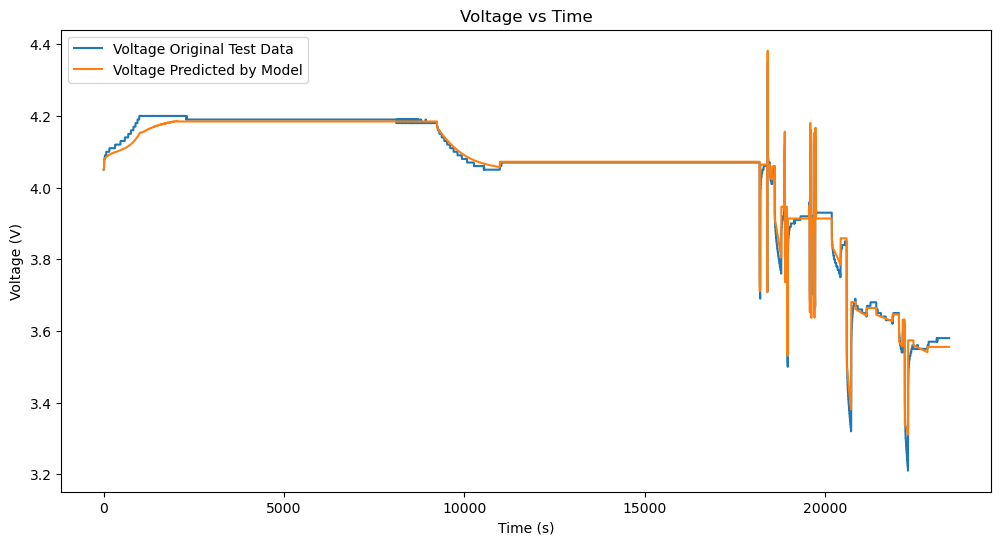

For C = 43.186375 MSE:0.00023908618704382312 Max error: 0.022964313615988528 


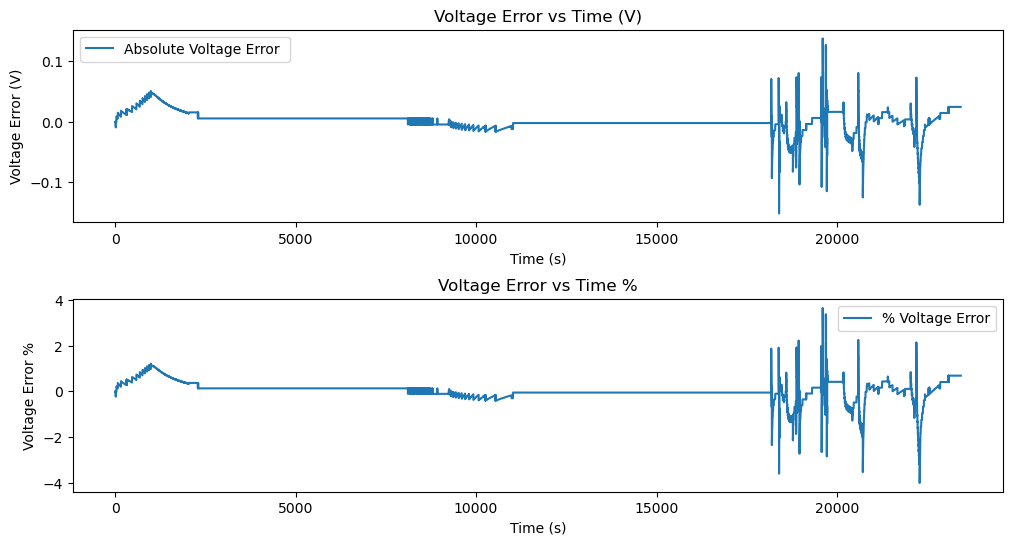

In [136]:
C1 = C1_T0
#C1 = 600
Tambient = 20 # in celsius
h_value = 35
volt_model , temp_model = part3_model(df_test,ocv_data,R0_Arrhenius, R0_Arrhenius_Params, new_R1_equation, R1_Gaussian_params, C1, Tambient, h_value)

plot_model(volt_model,df_test, start_time = 1, end_time = Time.max())

plot_model_errors(volt_model,df_test, start_time = 1, end_time = Time.max())
calc_errors(volt_model,df_test, C1)


Check the temperature errors 

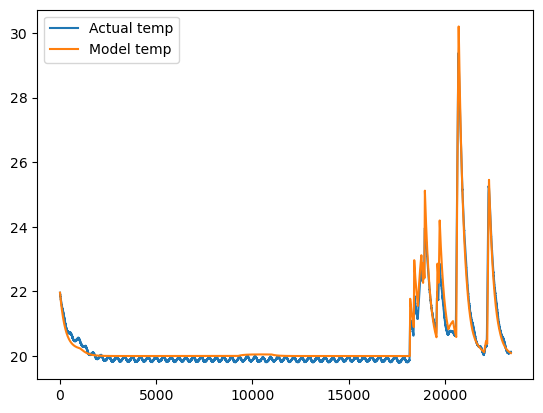

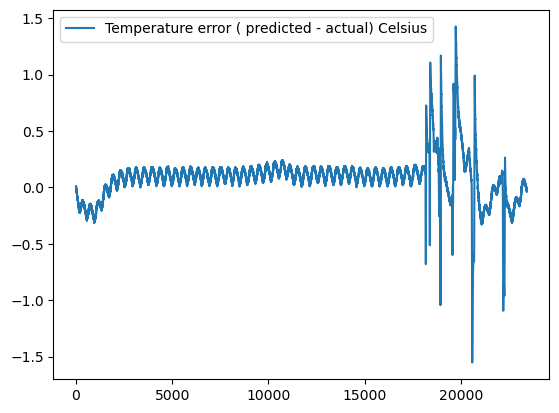

In [137]:
plt.plot(Time, Temp, label="Actual temp")
plt.plot(Time, temp_model, label="Model temp")
plt.legend()
plt.show()

plt.plot(Time, (temp_model - Temp ), label="Temperature error ( predicted - actual) Celsius")
plt.legend()
plt.show()